# Redes neuronales 2017
## Trabajo práctico 2

In [164]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [5]:
df = pd.read_csv('tp2_training_dataset.csv', header=None)

X = df.iloc[:,1:]
y = df.iloc[:,0]

# partición del conjunto de datos en conjuntos de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

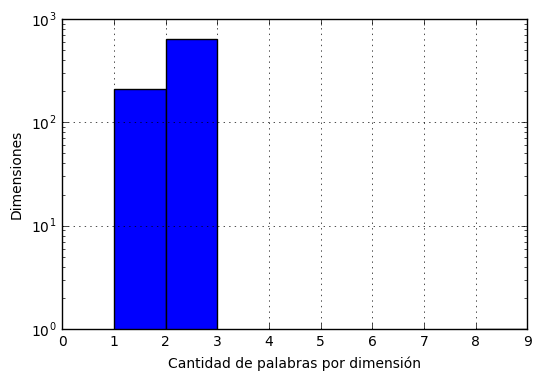

In [3]:
df[1:].max().hist(bins=range(10))
plt.yscale('log')
plt.xlabel('Cantidad de palabras por dimensión')
plt.ylabel('Dimensiones')
plt.savefig('histograma.pdf')

In [4]:
df[0].value_counts(sort=False)

1     98
2    100
3    100
4     98
5    102
6    106
7     98
8    101
9     97
Name: 0, dtype: int64

In [7]:
def lotes(X, y, n):
    if n < 1: n = len(X)
    
    for i in range(0, len(X), n):
        yield X[i:i+n], y[i:i+n]

        
def barajar(X, y):
    e = np.random.get_state()
    X = np.random.permutation(X)
    np.random.set_state(e)
    y = np.random.permutation(y)
    
    return X, y

## Parte 1

In [182]:
from sklearn.base import BaseEstimator

class NS(BaseEstimator):

    def __init__(self, inicialización=(-1,1), tamaño_lote=1, factor_aprendizaje=0.001, épocas=100, salidas=3, regla='sanger'):
        self.inicialización = inicialización
        self.tamaño_lote = tamaño_lote
        self.factor_aprendizaje = factor_aprendizaje
        self.épocas = épocas
        self.salidas = salidas
    
        if regla == 'Sanger':
            self.regla = lambda eta, X, Y, W: eta * (np.dot(X.T, Y) - np.dot(W, np.tril( np.dot(Y.T,Y) ) ) )
        elif regla == 'Oja':
            self.regla = lambda eta, X, Y, W: eta * np.dot( (X - np.dot(Y, W.T) ).T, Y)
        elif regla == 'Hebb':
            self.regla = lambda eta, X, Y, W: eta * np.dot(X.T, Y)
    
    
    def fit(self, X, y):
        # asegurarse de que 'y' sea 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        
        entradas = X.shape[1]
        
        forma = (entradas, self.salidas)
        self.W = np.random.uniform(low=self.inicialización[0], high=self.inicialización[1], size=forma)
         
        eta = self.factor_aprendizaje
        
        for época in range(self.épocas):
            _X, _y = barajar(X, y)
            
            for lote_X, lote_y in lotes(_X, _y, self.tamaño_lote):
                Y = np.dot(lote_X, self.W)
                self.W += self.regla(eta, lote_X, Y, self.W)
            
        return self

    
    def transform(self, X, y=None):
        return np.dot(X, self.W)
    
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [7]:
def plot_ns(X_test, y_test):
    proyecciones = [( 60, 60),(150, 60),
                    ( 60,150),(240,240),]
    
    plt.figure(figsize=(5, 5))
    
    for i,(a,b) in enumerate(proyecciones):
        ax = plt.subplot(2,2,i+1, projection='3d')
        ax.scatter(xs=X_test[:,0],  ys=X_test[:,1],  zs=X_test[:,2],  c=y_test,  marker='.', lw=0)
        ax.view_init(a, b)
    
        #ax.set_xlabel('x')
        #ax.set_ylabel('y')
        #ax.set_zlabel('z')

        # Get rid of the panes                          
        #ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
        #ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
        #ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 

        # Get rid of the spines                         
        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
        # Get rid of the ticks                          
        ax.set_xticks([])                               
        ax.set_yticks([])                               
        ax.set_zticks([])

In [8]:
def plot_ns_val(X_train, X_test):
    proyecciones = [( 60, 60),(150, 60),
                    ( 60,150),(240,240),]
    
    plt.figure(figsize=(5, 5))
    
    for i,(a,b) in enumerate(proyecciones):
        ax = plt.subplot(2,2,i+1, projection='3d')
        ax.scatter(xs=X_train[:,0], ys=X_train[:,1], zs=X_train[:,2], c='b', marker='.', lw=0)
        ax.scatter(xs=X_test[:,0],  ys=X_test[:,1],  zs=X_test[:,2],  c='r',  marker='.', lw=0)
        ax.view_init(a, b)
    
        #ax.set_xlabel('x')
        #ax.set_ylabel('y')
        #ax.set_zlabel('z')

        # Get rid of the panes                          
        #ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
        #ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
        #ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 

        # Get rid of the spines                         
        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
        # Get rid of the ticks                          
        ax.set_xticks([])                               
        ax.set_yticks([])                               
        ax.set_zticks([])

In [1197]:
def exp(regla, épocas, factor_aprendizaje):
    rn = NS(factor_aprendizaje=factor_aprendizaje, épocas=épocas, salidas=3, regla=regla)
    clf = make_pipeline(StandardScaler(), rn)
    clf.fit(X_train, y_train)

    plot_ns(clf.predict(X_test), y_test)
    plt.suptitle('Regla de %s - %s épocas - eta %s' % (regla, épocas, factor_aprendizaje))
    plt.savefig('%s_%s_%s.pdf' % (regla.lower(), épocas, factor_aprendizaje))

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


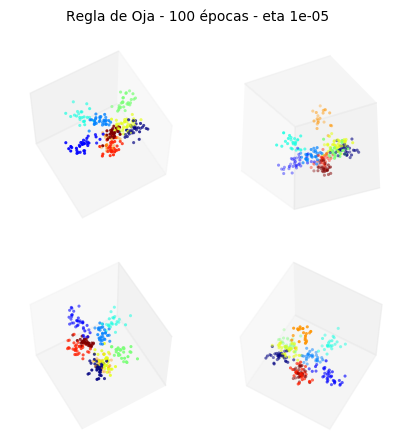

In [1213]:
exp('Oja', 100, 1e-5)

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


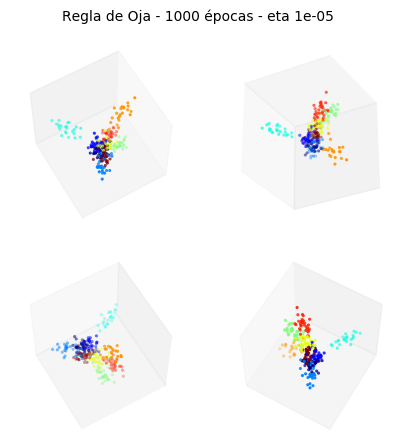

In [1214]:
exp('Oja', 1000, 1e-5)

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


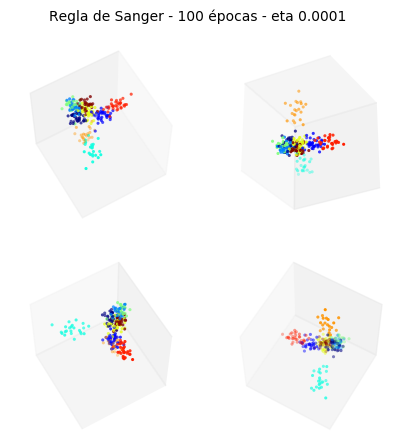

In [1206]:
exp('Sanger', 100, 1e-4)

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


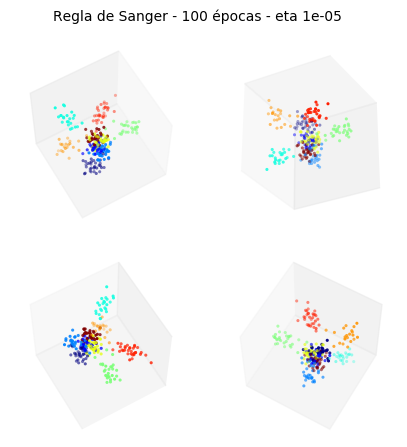

In [1208]:
exp('Sanger', 100, 1e-5)

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


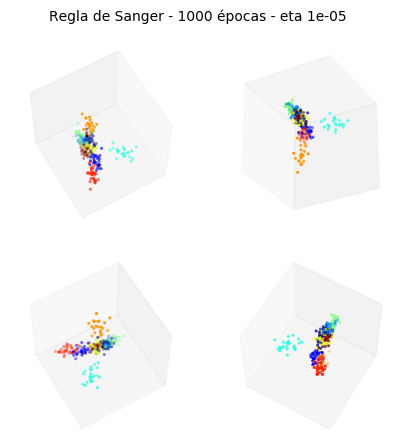

In [1209]:
exp('Sanger', 1000, 1e-5)

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


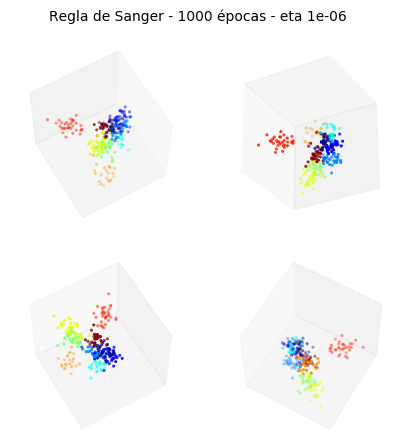

In [1211]:
exp('Sanger', 1000, 1e-6)

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


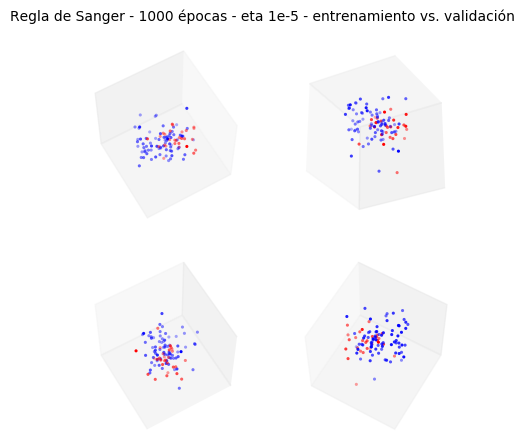

In [1215]:
rn = NS(factor_aprendizaje=1e-5, épocas=1000, salidas=3, regla='Sanger')
clf = make_pipeline(StandardScaler(), rn)
clf.fit(X_train, y_train)

plot_ns_val(clf.predict(X_train[y_train == 5]), clf.predict(X_test[y_test == 5]))
plt.suptitle('Regla de Sanger - 1000 épocas - eta 1e-05 - entrenamiento vs. validación')
plt.savefig('sanger_1000_1e-05_entrenamiento_validación.pdf')

## Parte 2

In [247]:
from itertools import product
from collections import Counter
from sklearn.base import BaseEstimator

class SOM(BaseEstimator):

    def __init__(self, inicialización=(-1,1), factor_aprendizaje=1, épocas=10, lado=3, fwhm_inicial=1):
        self.inicialización = inicialización
        self.factor_aprendizaje = factor_aprendizaje
        self.épocas = épocas
        self.lado = lado
        self.fwhm_inicial = fwhm_inicial
        
    
    def fit(self, X, y):
        # factor de aprendizaje
        L = lambda l0, t, T: l0 * (T-t) / T
        # función de proximidad
        O = lambda n1, n2, R, t, T: np.exp(-np.linalg.norm(n1 - n2)**2 / (2 * L(R,t,T)**2))

        # asegurarse de que 'y' sea 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        
        entradas = X.shape[1]
        W = lambda: np.random.uniform(low=self.inicialización[0], high=self.inicialización[1], size=entradas)
        self.nodos = [{'V':np.array((x,y)), 'W':W()} for x,y in product(range(self.lado), range(self.lado))]
        
        for época in range(self.épocas):
            _X, _y = barajar(X, y)
    
            for x, lote_y in lotes(_X, _y, 1):
                x = x.reshape(-1)
                bmd = float('inf')
                bmu = None
    
                # selección de la BMU (best matching unit) a partir de la BMD (best matching distance)
                for nodo in self.nodos:
                    distancia = np.linalg.norm(x - nodo['W'])
    
                    if distancia < bmd:
                        bmd = distancia
                        bmu = nodo
    
            # actualización de los pesos
            for nodo in self.nodos:
                nodo['W'] += L(self.factor_aprendizaje, época, self.épocas) * \
                             O(bmu['V'], nodo['V'], self.fwhm_inicial / 2.35, época, self.épocas) * (x - nodo['W'])
                
        return self
    
                 
    def transform(self, X, y):
        for nodo in self.nodos: nodo['contador'] = Counter()
        
        for x, _y in lotes(X, y, 1):
            x = x.reshape(-1)
            bmd = float('inf')
            bmu = None
    
            # selección del best matching unit
            for nodo in self.nodos:
                distancia = np.linalg.norm(x - nodo['W'])
    
                if distancia < bmd:
                    bmd = distancia
                    bmu = nodo
        
            bmu['contador'][_y.values[0]] += 1
        
        for nodo in self.nodos:
            if len(nodo['contador']) > 0:
                nodo['categoría'] = nodo['contador'].most_common()[0][0]
            else:
                nodo['categoría'] = np.nan
        
        return self.nodos
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [276]:
def plot_som(nodos, size=(4,4)):
    plt.figure(figsize=size)
    
    lado = int(np.sqrt(len(nodos)))
    matriz = np.zeros((lado,lado))

    for nodo in nodos:
        x = nodo['V'][0]
        y = nodo['V'][1]
        matriz[x][y] = nodo['categoría']
    
    ax = plt.gca()
    ax.matshow(matriz)
    ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labeltop='off')                         

In [354]:
def plot_som_comp(nodos, size=(4, 4)):
    plt.figure(figsize=size)

    lado = int(np.sqrt(len(nodos)))
    matriz = np.zeros((lado,lado))
    
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        
        for nodo in nodos:
            x = nodo['V'][0]
            y = nodo['V'][1]
            matriz[x][y] = nodo['contador'][i+1]
                       
        ax.matshow(matriz, cmap='Greys')
        ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labeltop='off')            

In [444]:
from sklearn.preprocessing import MaxAbsScaler

def experimento(save='/home/matias/redes-neuronales/tp2/som/', sanger=0, plot=plot_som, **args):
    som = SOM(**args)
    sanger = NS(factor_aprendizaje=1e-5, épocas=100, salidas=sanger, regla='Sanger')
    
    if sanger.salidas > 0:
        est = make_pipeline(
            MaxAbsScaler(),
            sanger,
            som,
        )
    else:
         est = make_pipeline(
            MaxAbsScaler(),
            som,
        )

    plot(est.fit_transform(X.values, y))

    vars = (som.lado, som.lado, som.épocas, som.factor_aprendizaje, som.fwhm_inicial, sanger.salidas)

    if plot == plot_som:
        plt.title( 'SOM {}x{} e:{} l:{} FWHM:{} Sanger:{}'.format(*vars) );
    else:
        plt.suptitle( 'SOM {}x{} e:{} l:{} FWHM:{} Sanger:{}'.format(*vars) )
        
    if save:
        if plot == plot_som:
            plt.savefig( save + 'som{}x{}_e{}_l{}_f{}_s{}.pdf'.format(*vars) )
        else:
            plt.savefig( save + 'som_comparado{}x{}_e{}_l{}_f{}_s{}.pdf'.format(*vars) )

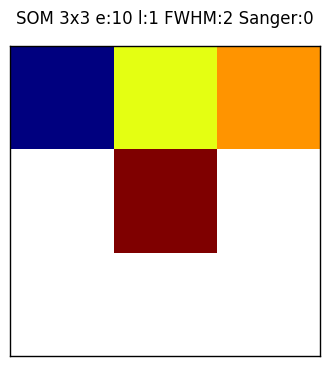

In [445]:
experimento(factor_aprendizaje=1, épocas=10, lado=3, fwhm_inicial=2)

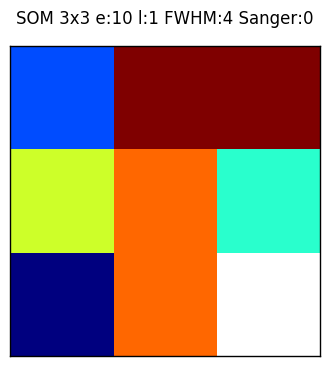

In [446]:
experimento(factor_aprendizaje=1, épocas=10, lado=3, fwhm_inicial=4)

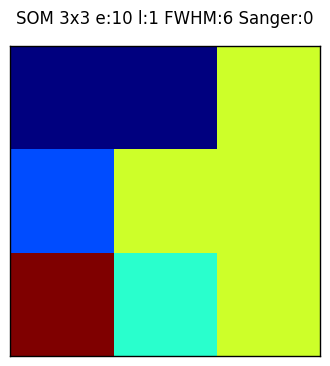

In [447]:
experimento(factor_aprendizaje=1, épocas=10, lado=3, fwhm_inicial=6)

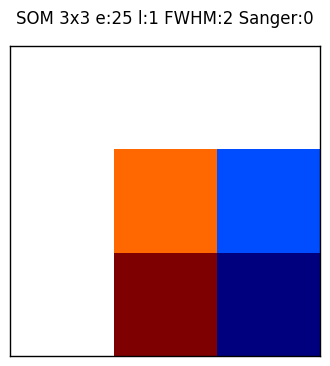

In [448]:
experimento(factor_aprendizaje=1, épocas=25, lado=3, fwhm_inicial=2)

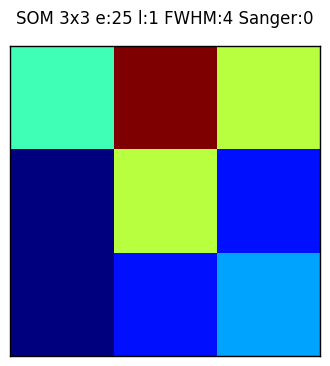

In [449]:
experimento(factor_aprendizaje=1, épocas=25, lado=3, fwhm_inicial=4)

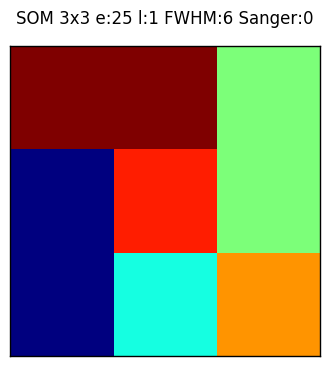

In [450]:
experimento(factor_aprendizaje=1, épocas=25, lado=3, fwhm_inicial=6)

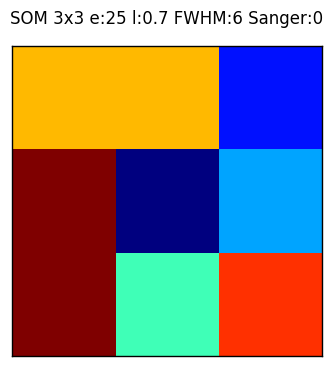

In [451]:
experimento(factor_aprendizaje=.7, épocas=25, lado=3, fwhm_inicial=6)

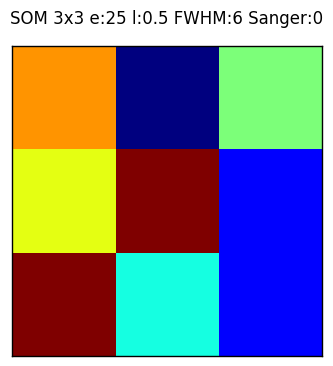

In [452]:
experimento(factor_aprendizaje=.5, épocas=25, lado=3, fwhm_inicial=6)

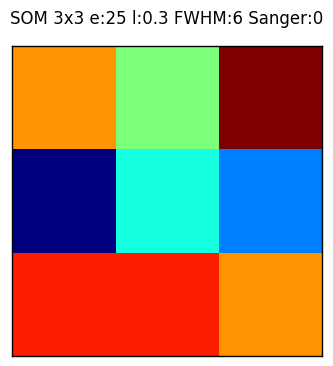

In [453]:
experimento(factor_aprendizaje=.3, épocas=25, lado=3, fwhm_inicial=6)

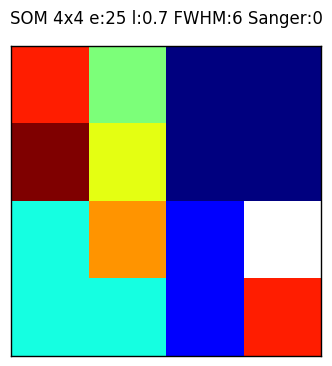

In [454]:
experimento(factor_aprendizaje=.7, épocas=25, lado=4, fwhm_inicial=6)

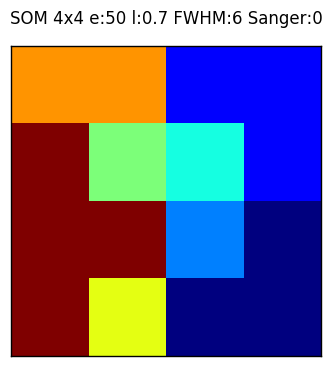

In [455]:
experimento(factor_aprendizaje=.7, épocas=50, lado=4, fwhm_inicial=6)

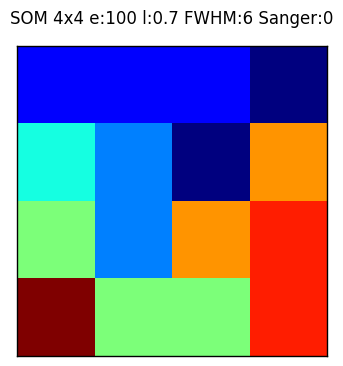

In [456]:
experimento(factor_aprendizaje=.7, épocas=100, lado=4, fwhm_inicial=6)

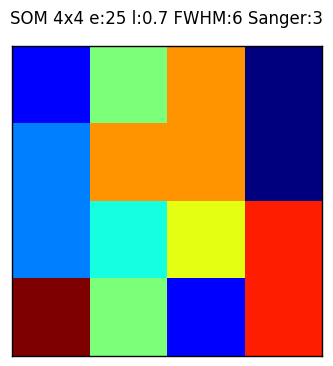

In [457]:
experimento(factor_aprendizaje=.7, épocas=25, lado=4, fwhm_inicial=6, sanger=3)

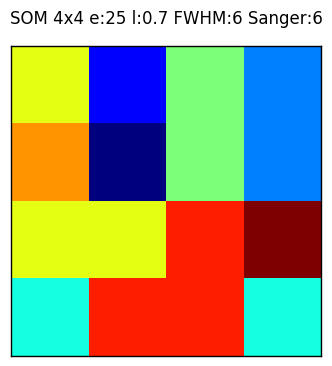

In [458]:
experimento(factor_aprendizaje=.7, épocas=25, lado=4, fwhm_inicial=6, sanger=6)

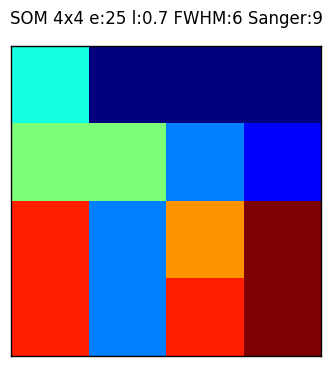

In [459]:
experimento(factor_aprendizaje=.7, épocas=25, lado=4, fwhm_inicial=6, sanger=9)

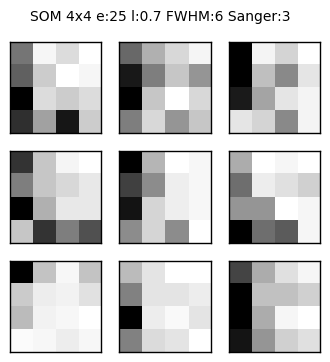

In [460]:
experimento(factor_aprendizaje=.7, épocas=25, lado=4, fwhm_inicial=6, sanger=3, plot=plot_som_comp)

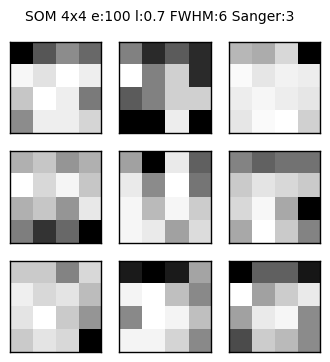

In [461]:
experimento(factor_aprendizaje=.7, épocas=100, lado=4, fwhm_inicial=6, sanger=3, plot=plot_som_comp)

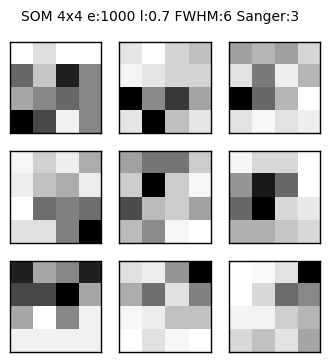

In [462]:
experimento(factor_aprendizaje=.7, épocas=1000, lado=4, fwhm_inicial=6, sanger=3, plot=plot_som_comp)

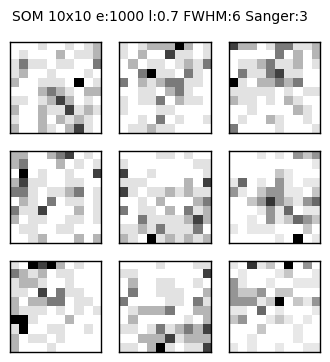

In [463]:
experimento(factor_aprendizaje=.7, épocas=1000, lado=10, fwhm_inicial=6, sanger=3, plot=plot_som_comp)